## 0. Introduction

The aim of this lab is to get familiar with **classification problems** and **logistic regression**. We will be using some code extracts that were implemented last week and build a logistic regression model.

1.   This lab is the second course-work activity **Assignment 1 Part 2: Classification**
2. Assignment 1 is split into 3 parts: Part 1 - Regression (Lab 3), and Part 2 - Classification (Lab 4) and Part 3 - Neural Networks (Lab 6). The three parts need to be submitted together by  **Monday, 11th November 2024, 10:00am**
3. All questions need to be completed and are assessed.
4. For each lab, a report answering the <font color = 'red'>**questions in red**</font> should be included along with the completed Notebook (.ipynb)
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.).
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. There are three parts of Assignment 1, therefore you should submit a zip file that contains 1 x Notebook and 1 x PDF for each part. In total: 3 x Notebooks and 3 x PDFs in the submission zip. Make sure the file is well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import typing
%matplotlib inline

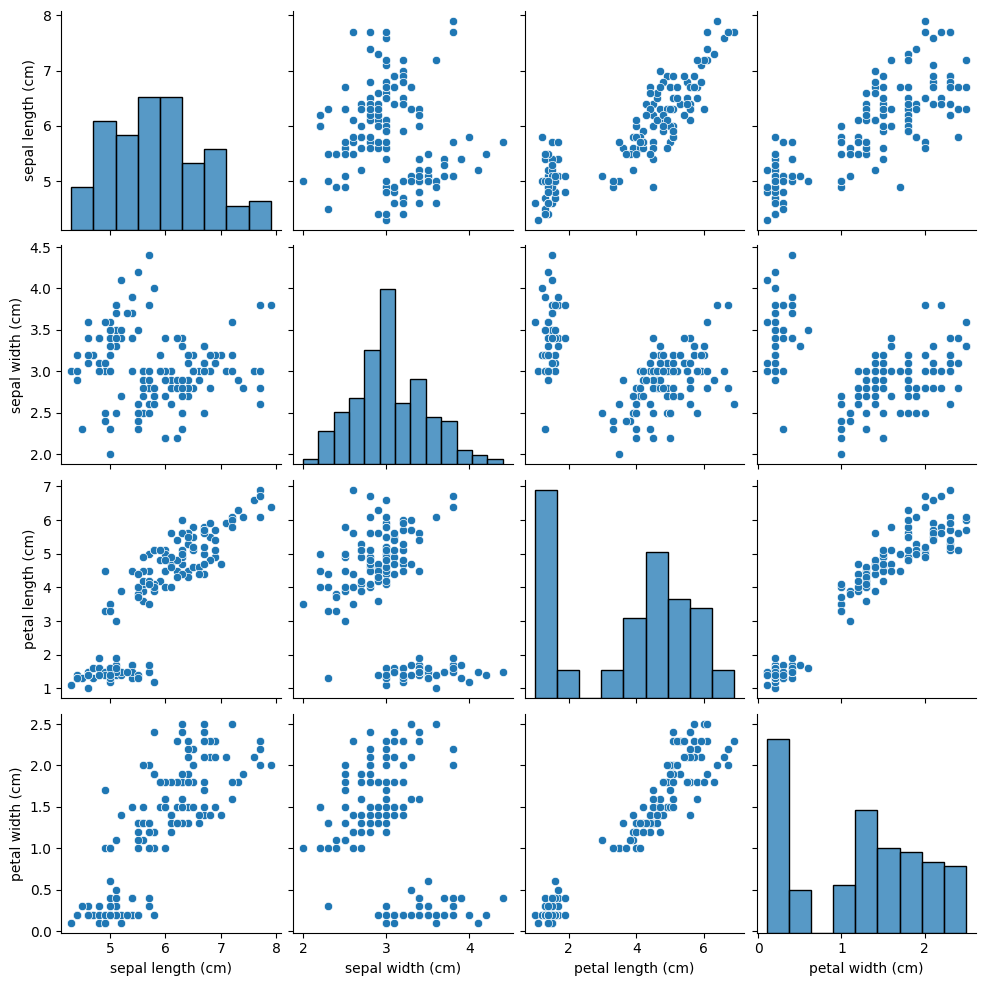

In [2]:
iris_db = datasets.load_iris(as_frame=True)
sns.pairplot(iris_db.data)

In [3]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

<font color="red">**Q1.** We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font>

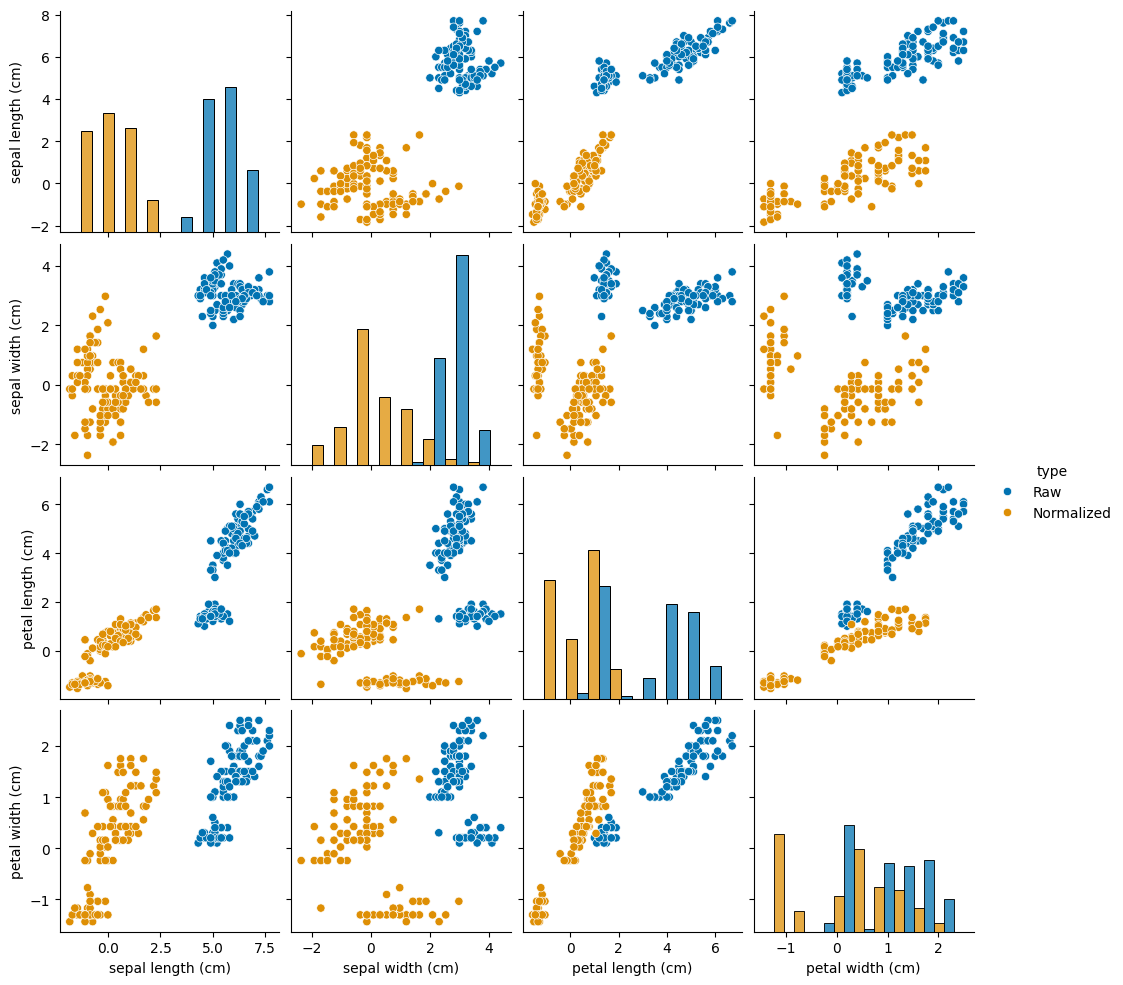

In [5]:
# Define normalization function
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    return (x - mu) / sigma

# Calculate mean and standard deviation of x_train
mean = x_train.mean(dim=0)
std = x_train.std(dim=0)

# Normalize x_train and x_test
x_train_normalized = norm_set(x_train, mean, std)
x_test_normalized = norm_set(x_test, mean, std)

# Assuming iris_db is the original data and x_train_normalized is the normalized data
x_train_df = pd.DataFrame(x_train.numpy(), columns=iris_db.feature_names)
x_train_normalized_df = pd.DataFrame(x_train_normalized.numpy(), columns=iris_db.feature_names)

# Add a label column to both raw and normalized data to differentiate them
x_train_df['type'] = 'Raw'
x_train_normalized_df['type'] = 'Normalized'

# Concatenate the two DataFrames
combined_df = pd.concat([x_train_df, x_train_normalized_df])

# Create the pairplot with both raw and normalized data
sns.pairplot(combined_df, hue='type', diag_kind="hist", palette="colorblind", diag_kws={'multiple': 'dodge'})
plt.show()


In [6]:
x_train = x_train_normalized
x_test = x_test_normalized

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

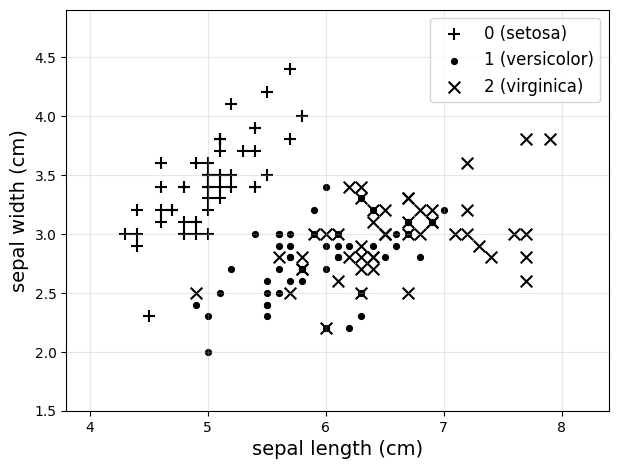

In [7]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [8]:
# we are using normalized data instead of the raw x_train and x_test
train_set_1 = x_train[:, :2]
test_set_1 = x_test[:, :2]


train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1) #feature for bias added for test and train
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()


## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

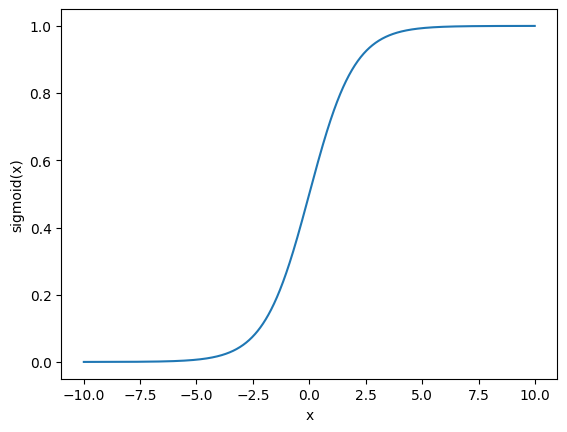

In [9]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
  z = 1/(1 + torch.exp(-z))
  return z


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [10]:
class LogisticRegression(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

    def forward(self, x):
        # Linear combination (no need to transpose self.weight)
        z = x @ self.weight.T
        # Apply sigmoid activation to get probabilities between 0 and 1
        y = torch.sigmoid(z)
        return y

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m}  \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**Q4.** Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

In [11]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  N = y_true.shape[0]
  return (-1/N)*torch.sum(((1-y_true) * torch.log(1-y_pred))+(y_true * torch.log(y_pred)))


def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
    # Get the model weight
    weight = model.weight
    N = X.shape[0]  # Number of examples


    # Compute the gradient (partial derivative of the BCE loss with respect to weights)
    pd = sum(((y_pred - y) * X)/N)

    # Update the weights
    weight = weight - lr * pd

    # Assign the new weight back to the model
    model.weight = nn.Parameter(weight, requires_grad=False)



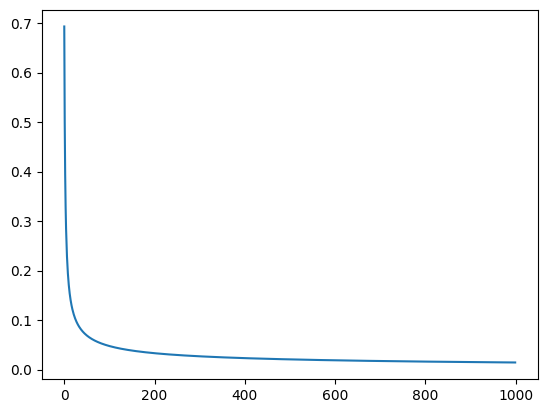

Parameter containing:
tensor([[-7.6483,  4.1452, -4.5710]])
Minimum cost: 0.01426516380161047


In [12]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y, prediction, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 1 # select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

<font color="red"> **Q5.** Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font>

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


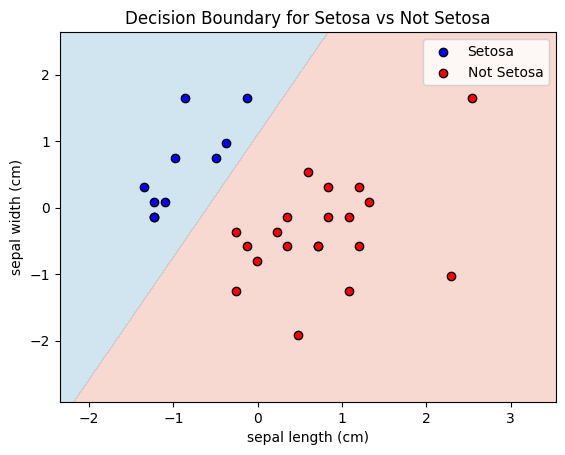

In [13]:
# First, find the minimum and maximum values for the plot range
feature1_min, feature1_max = torch.min(test_set_1[:, 0]) - 1, torch.max(test_set_1[:, 0]) + 1
feature2_min, feature2_max = torch.min(test_set_1[:, 1]) - 1, torch.max(test_set_1[:, 1]) + 1


x_mesh, y_mesh = torch.meshgrid(
    torch.arange(feature1_min, feature1_max, 0.01),
    torch.arange(feature2_min, feature2_max, 0.01)
) #pytroch meschrgird function

# Flatten the grid and add a bias term for predictions
input_grid = torch.cat([x_mesh.reshape(-1, 1), y_mesh.reshape(-1, 1), torch.ones(x_mesh.numel(), 1)], dim=1)

# predict on the grid to get decision boundary values
boundary_predictions = model(input_grid).detach().numpy()
boundary_predictions = boundary_predictions.reshape(x_mesh.shape)

# plot the decision boundary
plt.contourf(x_mesh.numpy(), y_mesh.numpy(), boundary_predictions, levels=[0, 0.5, 1], alpha=0.3, cmap='RdBu')

# plot the actual test points with color coding for Setosa and Not Setosa
setosa_test_labels = setosa_test.squeeze()
setosa_samples = test_set_1[setosa_test_labels == 1]
not_setosa_samples = test_set_1[setosa_test_labels == 0]

plt.scatter(setosa_samples[:, 0].numpy(), setosa_samples[:, 1].numpy(), color='blue', edgecolors='k', marker='o', label='Setosa')
plt.scatter(not_setosa_samples[:, 0].numpy(), not_setosa_samples[:, 1].numpy(), color='red', edgecolors='k', marker='o', label='Not Setosa')

plt.xlabel(iris_db.feature_names[0])
plt.ylabel(iris_db.feature_names[1])
plt.title('Decision Boundary for Setosa vs Not Setosa')
plt.legend()
plt.show()




## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [14]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


In [15]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


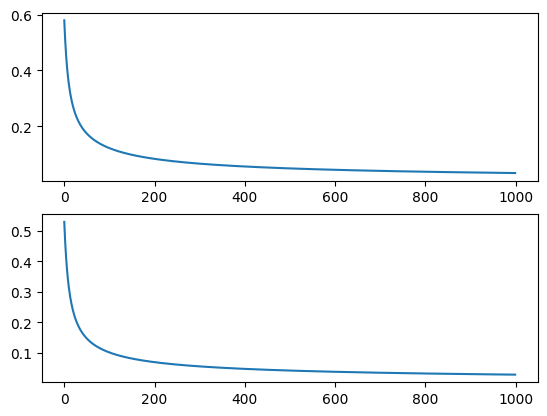

Minimum train cost: 0.03221553936600685
Minimum test cost: 0.027501961216330528


In [16]:
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)


In [17]:

print("Shape of x_train:", x_train.shape)
print("Shape of setosa_labels:", setosa_labels.shape)


print("Shape of x_test:", x_test.shape)
print("Shape of setosa_testy:", setosa_testy.shape)


Shape of x_train: torch.Size([120, 4])
Shape of setosa_labels: torch.Size([120, 1])
Shape of x_test: torch.Size([30, 4])
Shape of setosa_testy: torch.Size([30, 1])


How does the cost of the 4 attribute model compare to the previous one?
it is lower



**Q6** Now train classifiers for the other two classes.[1 mark]

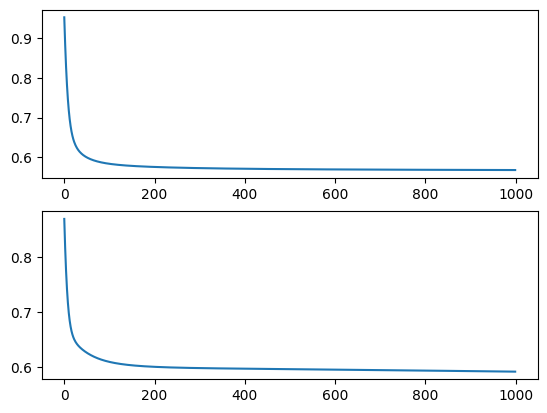

Minimum train cost: 0.5675528645515442
Minimum test cost: 0.591107964515686


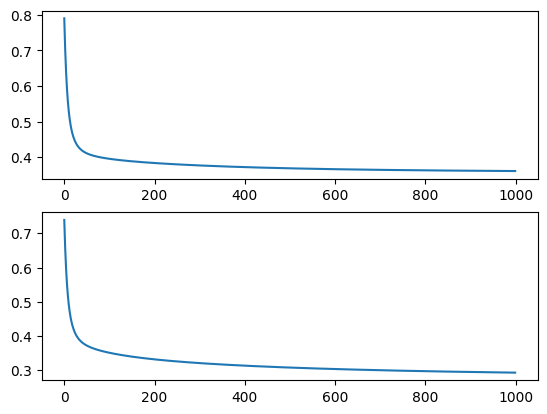

Minimum train cost: 0.3613908588886261
Minimum test cost: 0.2931031584739685


In [18]:
alpha = 0.1

versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser = optim.SGD(versicolor_model.parameters(), alpha)
train(versicolor_model, x_train, versicolor_labels, x_test, versicolor_testy, optimiser, alpha)

virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser = optim.SGD(virginica_model.parameters(), alpha)
train(virginica_model, x_train, virginica_labels, x_test, virginica_testy, optimiser, alpha)

<font color="red"> **Q7.** Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font>

In [19]:
import pandas as pd

# predict probabilities for each class using the classifiers
with torch.no_grad():
    setosa_pred = setosa_model(x_test)
    versicolor_pred = versicolor_model(x_test)
    virginica_pred = virginica_model(x_test)


all_predictions = torch.cat([setosa_pred, versicolor_pred, virginica_pred], dim=1) # concatenate the predictions into a tensor


predicted_classes = torch.argmax(all_predictions, dim=1) # Get the index of the maximum value (highest probability) for each row

# Convert predictions and true labels to a DataFrame for better visualization
predictions_df = pd.DataFrame({
    'Sample Index': range(len(x_test)),
    'Setosa Probability': setosa_pred.squeeze().numpy(),
    'Versicolor Probability': versicolor_pred.squeeze().numpy(),
    'Virginica Probability': virginica_pred.squeeze().numpy(),
    'Predicted Class': predicted_classes.numpy(),
    'True Class': y_test.argmax(dim=1).numpy()
})


predictions_df


,Sample Index,Setosa Probability,Versicolor Probability,Virginica Probability,Predicted Class,True Class
0,0,0.031686,0.742628,0.468116,1,1
1,1,0.999956,0.171084,0.107524,0,0
2,2,0.000003,0.840261,0.944698,2,2
3,3,0.038570,0.590015,0.708054,2,1
4,4,0.006947,0.767417,0.523042,1,1
5,5,0.999650,0.316023,0.075939,0,0
6,6,0.294768,0.547496,0.523592,1,1
7,7,0.002135,0.377276,0.965983,2,2
8,8,0.000431,0.915790,0.368473,1,1
9,9,0.075589,0.733577,0.369032,1,1


<font color="red"> **Q8.** Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font>

In [20]:


# Calculate softmax over the combined predictions from each classifier
with torch.no_grad():
    setosa_pred = setosa_model(x_test)
    versicolor_pred = versicolor_model(x_test)
    virginica_pred = virginica_model(x_test)

# Stack predictions and apply softmax
all_predictions = torch.cat([setosa_pred, versicolor_pred, virginica_pred], dim=1)
softmax_predictions = F.softmax(all_predictions, dim=1)

# Get predicted classes (index with the highest probability after softmax)
predicted_classes = torch.argmax(softmax_predictions, dim=1)

# Calculate accuracy by comparing predicted_classes to true classes
true_classes = y_test.argmax(dim=1)  # Assuming y_test is one-hot encoded
accuracy = (predicted_classes == true_classes).float().mean().item() * 100

# Print accuracy
print(f"Accuracy on test set: {accuracy:.2f}%")


Accuracy on test set: 90.00%


In [21]:
true_classes

tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 0, 0])

In [22]:
predicted_classes

tensor([1, 0, 2, 2, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 0, 2, 0, 2,
        2, 2, 1, 2, 0, 0])

## 3. The XOR problem

<font color="red"> **Q9.** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? [2 marks] </font>

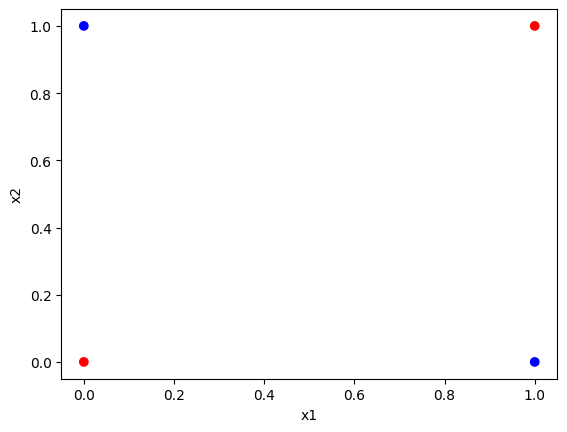

In [23]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()